In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy
from scipy import stats

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [42]:
N = 100
x = np.array(np.random.randn(N))
print(x)

[ 0.36814006  1.78113139 -0.50970827 -0.76194639 -1.73611229 -0.94860785
  0.49372268 -1.34233267  0.04077536  0.51445867 -2.0243804   0.45399227
  0.82599822  1.87145796 -1.07204753  0.6554984  -1.27185259  0.59923314
 -0.17753843 -2.35374611 -0.2509684   0.7514097   0.94009288  0.34218887
  2.00245312 -1.36072411 -0.93187715 -0.01501767  1.17282158 -1.81471489
 -0.47007336 -1.02809857  0.7217923  -0.28749623  0.17136903  0.30784316
 -1.44708457 -0.43232795 -0.23424033 -2.31620493  0.45733834 -0.61137456
  1.50716277  1.41864141  0.43216798  0.19010317  0.71769654  0.33038377
  1.29655887 -1.51776987 -0.21000352 -0.15532889  0.44618475 -0.08015422
  0.58697144 -0.69554083  0.01580586 -2.11381686  0.89056859  1.65338066
  0.06637071  1.13688515  2.5610732  -0.11132622 -0.0612463  -0.55587762
 -1.15708916 -1.01051126 -0.57074429  1.25236393  0.02849416 -0.6752996
  1.55575164  1.20349721 -0.93548141  2.21716112  1.28414448 -0.97407
 -0.6885859  -1.48018842  1.54476629 -1.22822592  0.805

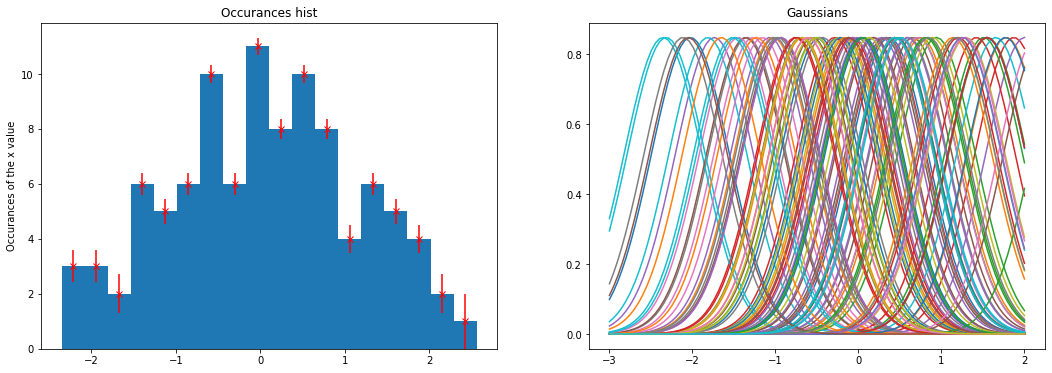

In [43]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 6)
ax[0].set_title("Occurances hist")
ax[0].set_ylabel("Occurances of the x value")
bins = ax[0].hist(x, bins=18)
ax[0].locator_params(axis="y",integer = True);

#print(bins)

#poisson uncertainty for errors
p_uncertainty = 1 / np.sqrt(bins[0])
err = (bins[1][:-1] + bins[1][1:])/2
ax[0].errorbar(err, bins[0], yerr=p_uncertainty, fmt="x", color="red")

# gaussians
ax[1].set_title("Gaussians")

std = 1.06*x.std()* (x.size ** (- 1/5)) # by the formulation
points = np.linspace(np.min(x)//1, np.max(x)//1, 100)  # smoothing the curve
gaussians = np.zeros((len(points),0))
for i in range(N):
    distribution = stats.norm.pdf(points, loc=x[i], scale=std).reshape(100,1) 
    gaussians = np.concatenate([gaussians, distribution], axis = 1)
    ax[1].plot(points, distribution)

(array([0.12207977, 0.08138651, 0.12207977, 0.12207977, 0.20346628,
        0.28485279, 0.20346628, 0.32554605, 0.24415954, 0.40693256,
        0.28485279, 0.40693256, 0.28485279, 0.12207977, 0.32554605,
        0.20346628, 0.12207977, 0.08138651, 0.08138651, 0.04069326]),
 array([-2.35374611, -2.10800514, -1.86226418, -1.61652321, -1.37078225,
        -1.12504128, -0.87930032, -0.63355935, -0.38781838, -0.14207742,
         0.10366355,  0.34940451,  0.59514548,  0.84088644,  1.08662741,
         1.33236838,  1.57810934,  1.82385031,  2.06959127,  2.31533224,
         2.5610732 ]),
 <a list of 20 Patch objects>)

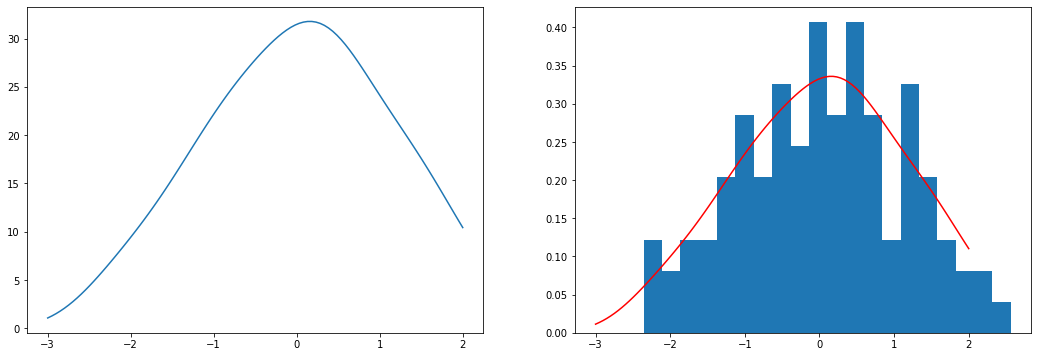

In [44]:
# Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the scipy.integrate.trapz() method
fig, ax = plt.subplots(1, 2)
gauss_sum = np.sum(gaussians, axis = 1)
area = scipy.integrate.trapz(gauss_sum, points)
norm_sum = gauss_sum / area

#plot
fig.set_size_inches(18, 6)
ax[0].plot(points, gauss_sum)
ax[1].plot(points, norm_sum, color="red")
ax[1].hist(x, bins=20, density=True)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-17 19:52:00--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2020-11-17 19:52:05--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceb48a4dbd1ee47cc6759e22251.dl.dropboxusercontent.com/cd/0/inline/BDY69og-JvZe_VeCPb4UWQAQRQsauFufVAVlCHaiyx8AM6myIJs6qK20U5TqVWGNYqZeudY8F-_i_RhkCcGMyRby183Wjyn7NV-da-Ep5qLx5A/file# [following]
--2020-11-17 19:52:05--  https://uceb48a4dbd1ee47cc6759e22251.dl.dropboxusercontent.com/cd/0/inline/BDY69og-JvZe_VeCPb4UWQAQRQsauFufVAVlCHaiyx8AM6myIJs6qK20U5TqVWGNYqZeudY8F-_

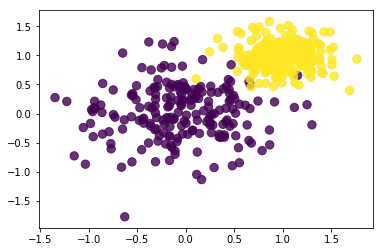

In [5]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [6]:
n = 4 # number of categories

# changing the number of categories is useful to change the interval for the randint function
# in order to have an understandable plot
# it is useful to change the number of samples for category too

mean =  np.random.randint(10, size=(n, 2))
cov = [[1,0], [0,1]] # diagonal covariance

df = [] # list for separate dataframes
for i in range(n):
    x, y = np.random.multivariate_normal(mean[i], cov, 200).T
    c = [i for j in range(200)]
    df_i = pd.DataFrame({"x" : x,
                            "y" : y,
                            "category" : c })
    df.append(df_i)

# create dataframe
result =  pd.concat(df, ignore_index=True, verify_integrity=True)
result

,x,y,category
0,7.619208,-0.038424,0
1,7.826854,1.946837,0
2,6.916398,1.013407,0
3,6.784280,0.868685,0
4,8.304541,1.335480,0
...,...,...,...
795,9.238646,8.619913,3
796,7.520509,9.096737,3
797,10.105366,7.791652,3
798,7.669858,8.306660,3


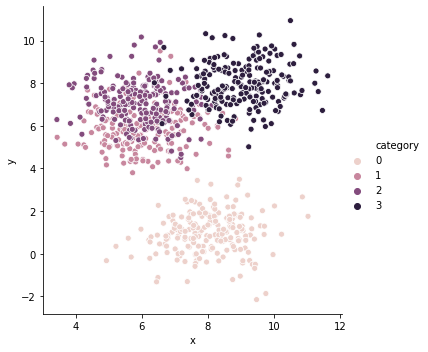

In [7]:
# plot the result
sns.relplot(x="x", y="y", hue="category", data=result)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [8]:
# download the resource
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2020-11-17 19:52:06--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2020-11-17 19:52:07--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc40c191ed852805e30f8e42057c.dl.dropboxusercontent.com/cd/0/inline/BDa1U2qBdHfd6y91JTFSIB-KK2pxeS_MCgpXpyj0y-CESynkxM75LrKjGqrLLKjcDdU8d2_Sen7fRud3LQSoYCCDil9On-1wNLWFA6rEMdG-Pg/file# [following]
--2020-11-17 19:52:07--  https://uc40c191ed852805e30f8e42057c.dl.dropboxusercontent.com/cd/0/inline/BDa1U2qBdHfd6y91JTFSIB-KK2pxeS_MCgpXpyj0y-CESynkxM75LrKjGqrLLKjcDdU8d2_Sen7fRud3LQSoYCCDil9On-1wNLWFA6rEMdG-Pg/file
R

In [9]:
data = np.load('residuals_261.npy', allow_pickle=True) # compose by residuals and distances categories
df = pd.DataFrame(data.item(), columns=["residuals", "distances"]).rename(columns = {"residuals": "residual", "distances": "distance"}, inplace = False)

In [10]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11131 entries, 0 to 11130
Columns: 2 entries, residual to distance
dtypes: float64(2)
memory usage: 174.0 KB


In [11]:
df

,residual,distance
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [12]:
# remove the values > 2 in abs value
df = df[abs(df["residual"]) <= 2]
df

,residual,distance
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [13]:
# linear regrassion
slope, intercept, r_value, p_value, std_err = stats.linregress(df["residual"], df["distance"])
predict_y = slope * df["residual"] + intercept

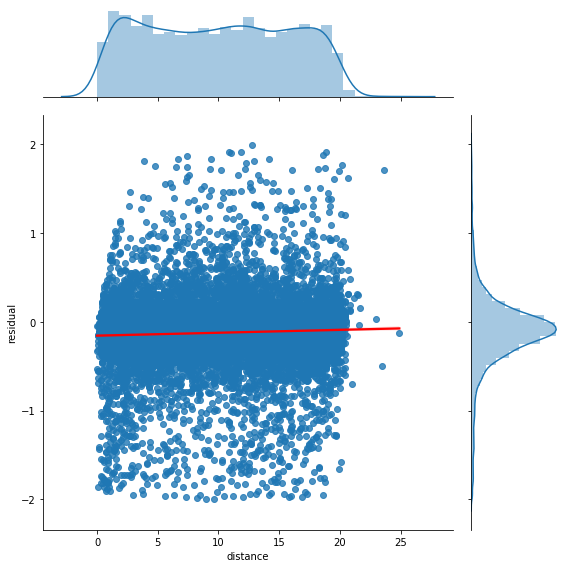

In [14]:
#plot a seaborn jointplot of "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
sns.jointplot(data=df, x="distance", y="residual", kind="reg", height=8, ratio=4, line_kws={"color": "red"})

In [15]:
# numpy arrays
n_bin = 30

# divide distances by bin and get x array
distance = df.sort_values(by=["distance"])["distance"]
bin_length = (np.max(distance) - np.min(distance)) / n_bin
bin_index = np.array([np.min(distance) + bin_length * i for i in range(1, n_bin)])
x = np.digitize(distance, bin_index) 
print(x)

# add bin index as new column 
df["bin"] = x

[ 0  0  0 ... 28 28 29]


In [16]:
df

,residual,distance,bin
0,1.100000,16.0,0
1,-1.950000,6.3,0
8,-0.042857,3.3,0
9,0.128571,5.3,0
10,0.085714,15.0,0
...,...,...,...
11126,-0.760000,14.4,26
11127,0.380000,7.5,27
11128,0.083333,1.7,28
11129,0.166667,19.1,28


In [17]:
margins = np.histogram_bin_edges(distance, n_bin)
x = (margins[:-1]+ margins[1:])/2 
print(x)

[ 0.415  1.245  2.075  2.905  3.735  4.565  5.395  6.225  7.055  7.885
  8.715  9.545 10.375 11.205 12.035 12.865 13.695 14.525 15.355 16.185
 17.015 17.845 18.675 19.505 20.335 21.165 21.995 22.825 23.655 24.485]


In [18]:
# y and erry array
y = []
erry = []
for i in range(n_bin):
    bin_residual = df[df["bin"] == i]["residual"]
    y.append(np.mean(bin_residual))
    erry.append(np.std(bin_residual))

y = np.array(y)
erry = np.array(erry)
print(y)
print(erry)

[-0.17605714 -0.12205013 -0.14283119 -0.11857307 -0.13493081 -0.15652715
 -0.11211285 -0.1426739  -0.11193552 -0.10132753 -0.09019158 -0.1262793
 -0.11496316 -0.11322776 -0.16505294 -0.10257795 -0.07388928 -0.16336834
 -0.12779416 -0.11083714 -0.1067736  -0.1191299  -0.08451127 -0.154675
 -0.04106151 -0.2075     -1.14        0.38        0.125       0.08333333]
[0.46110503 0.39132636 0.44601834 0.38393857 0.41672291 0.4556074
 0.48146439 0.38413449 0.38943336 0.43961431 0.44847349 0.45805219
 0.35065301 0.39752976 0.46835428 0.44747647 0.36423031 0.51480231
 0.42125767 0.49920392 0.48456164 0.48651608 0.49051128 0.43240483
 0.31797582 0.6267326  0.38       0.         0.04166667 0.        ]


<ErrorbarContainer object of 3 artists>

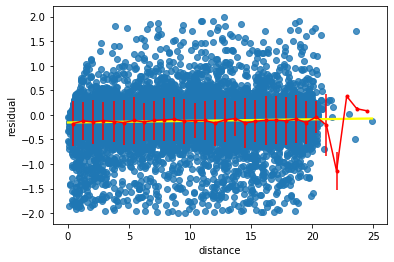

In [19]:
#plot a seaborn jointplot of "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
sns.regplot(data=df, x="distance", y="residual", line_kws={"color": "yellow"})
plt.errorbar(x=x, y=y , yerr=erry, marker = ".", color = "red")